# Moderation Analysis

In [89]:
# Import necessary libraries
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
from collections import Counter
import re
import seaborn as sns

### Loading and Examining Data Structure

In [90]:
# Load the cleaned dataset
reddit_df = pd.read_csv('../../topic_model_results.csv', lineterminator='\n', encoding='utf8')

reddit_df['moderation'] = reddit_df['moderation\r'].apply(ast.literal_eval)

### Check Data Structure

In [91]:
# See full content of each entry
pd.set_option('display.max_colwidth', None)

# Check the total number of rows in the dataset
total_rows = reddit_df.shape[0]
print(f"Total number of rows: {total_rows}")

# Check if there are any null values in the 'moderation' column
null_moderation_count = reddit_df['moderation'].isnull().sum()
print(f"Number of rows with null moderation: {null_moderation_count}")

Total number of rows: 396298
Number of rows with null moderation: 0


### Understanding the Moderation Keys

In [92]:
# Get all unique keys in the moderation column
all_keys = set().union(*(d.keys() for d in reddit_df['moderation']))

# Print unique keys
print("Unique keys in moderation:", all_keys)

# Function to handle non-list and list values separately
def get_unique_values(key):
    # Check if the value is a list or not
    if reddit_df['moderation'].apply(lambda x: isinstance(x.get(key), list)).any():
        # For lists, flatten them and get unique elements
        all_list_values = [item for sublist in reddit_df['moderation'].apply(lambda x: x.get(key)).dropna() for item in sublist]
        return set(all_list_values)
    else:
        # For non-list values, just return the unique values
        return reddit_df['moderation'].apply(lambda x: x.get(key)).unique()

# Loop through all keys and print their unique values
for key in all_keys:
    unique_values = get_unique_values(key)
    print(f"Unique values for {key}: {unique_values}")
    
# Check the first few entries of the moderation column
print(reddit_df['moderation'].head(10))

Unique keys in moderation: {'collapsed', 'collapsed_reason_code', 'num_reports', 'author_is_blocked', 'mod_reports', 'user_reports', 'mod_reason_by', 'banned_by', 'collapsed_reason', 'mod_reason_title', 'removal_reason', 'controversiality', 'mod_note', 'report_reasons', 'banned_at_utc'}
Unique values for collapsed: [False  True]
Unique values for collapsed_reason_code: [None 'LOW_SCORE' 'DELETED']
Unique values for num_reports: [nan  0.]
Unique values for author_is_blocked: [None False]
Unique values for mod_reports: set()
Unique values for user_reports: set()
Unique values for mod_reason_by: [None]
Unique values for banned_by: [None]
Unique values for collapsed_reason: [None 'comment score below threshold']
Unique values for mod_reason_title: [None]
Unique values for removal_reason: [None 'legal']
Unique values for controversiality: [0 1]
Unique values for mod_note: [None]
Unique values for report_reasons: set()
Unique values for banned_at_utc: [None]
0           {'removal_reason': No

### Flagging Different Types of Moderation Actions

#### Creating Flags for Key Moderation Action + Seeing Their Distribution

In [93]:
# Create boolean flags for collapsed, deleted, low-score, removed, and controversial comments
reddit_df['is_collapsed'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed') == True)
reddit_df['is_deleted'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'DELETED')
reddit_df['is_low_score'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'LOW_SCORE')
reddit_df['is_removed'] = reddit_df['moderation'].apply(lambda x: x.get('removal_reason') is not None)
reddit_df['is_controversial'] = reddit_df['moderation'].apply(lambda x: x.get('controversiality') == 1)

# Print counts for each flag to verify
print(f"Collapsed comments: {reddit_df['is_collapsed'].sum()}")
print(f"Deleted comments: {reddit_df['is_deleted'].sum()}")
print(f"Low-score comments: {reddit_df['is_low_score'].sum()}")
print(f"Removed comments: {reddit_df['is_removed'].sum()}")
print(f"Controversial comments: {reddit_df['is_controversial'].sum()}")

Collapsed comments: 15696
Deleted comments: 576
Low-score comments: 8228
Removed comments: 8
Controversial comments: 15373


After examining the csv closely, we realised that 'removed' comments are typically not flagged out in the moderation column. Instead, they will replace the text in the text column. 

For example,
"your submission has been removed because it doesnt have any content apart from the link if you wish to discuss content found in your link consider submitting it as a link post eg news or opinion articles or a self post if you intend to be much more detailed eg referencing multiple sources

i am a bot and this action was performed automatically please contact the moderators of this subredditmessagecomposetorsingapore if you have any questions or concerns"

"hello and thank you for posting to singapore it seems you have previously posted a submission  within the past 3 hours so your post has been removed as per the post frequency rule please wait 3 hours before submitting a new post if you believe your post has been removed by mistake please message the moderatorshttpswwwredditcommessagecomposeto2fr2fsingapore

 boop bleep i am a bot concerns message rsingaporehttpswwwredditcommessagecomposeto2fr2fsingaporeampsubjectproblem20with20bot previous posts mv7fojhttpswwwredditcomrsingaporecommentsmv7foj  limit 1 per 3h  next eligiblity 20210421 0636 utc"

Therefore, we have decided to 
1) Change our way of flagging for removed comments: now we will check for them in the text column.
2) Check for unique text values with the word 'removed' from the text column to validate the flag

In [94]:
# Update boolean flags to check moderation status
reddit_df['is_collapsed'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed') == True)
reddit_df['is_deleted'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'DELETED')
reddit_df['is_low_score'] = reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'LOW_SCORE')

# Update the 'is_removed' flag to check for "removed" in the text column
reddit_df['is_removed'] = reddit_df['text'].str.contains('removed', case=False, na=False)

# Flag for controversial comments as before
reddit_df['is_controversial'] = reddit_df['moderation'].apply(lambda x: x.get('controversiality') == 1)

# Print counts for each flag to verify
print(f"Collapsed comments: {reddit_df['is_collapsed'].sum()}")
print(f"Deleted comments: {reddit_df['is_deleted'].sum()}")
print(f"Low-score comments: {reddit_df['is_low_score'].sum()}")
print(f"Removed comments: {reddit_df['is_removed'].sum()}")
print(f"Controversial comments: {reddit_df['is_controversial'].sum()}")

Collapsed comments: 15696
Deleted comments: 576
Low-score comments: 8228
Removed comments: 1463
Controversial comments: 15373


In [95]:
# Filter rows where the 'is_removed' flag is True
removed_texts = reddit_df[reddit_df['is_removed']]['text'].unique()

# Display 20 unique 'text' values that contain "removed"
for i, text in enumerate(removed_texts[:20]):
    print(f"Removed Text {i+1}:\n{text}\n")

Removed Text 1:
your submission has been removed because it doesnt have any content


i am a bot and this action was performed automatically please contact the moderators of this subredditmessagecomposetorsingapore if you have any questions or concerns

Removed Text 2:
so we can drop further to something like 1years 9 months without bmt

and those who volunteer to take up scsocs to get their ns extended and get paid as regulars

scsocs have their vocation portion which can be removed and im in the opinion of scsocs for regulars only 

not enough pplpay moremore flexible regular plans

asa can be replaced with dxos wouldnt that be better lesser hand take over

Removed Text 3:
i would admit religion would have some influence in politics ie christian right and the republican party in usa

but are religious forces that strong in singapore i mean is pretty clear that they said they wont enforce it why not just removed it and not risk it we are lucky so far that we do not have a hyper nation

From the snippet of text with the word 'removed', some are accurately flagged but some are part of actual comments. We will filter in more detail.

As long as there is 'removed','bot' or 'removed','government', it should be the correct context for a removed comment. We will filter again

In [96]:
# Update the 'is_removed' flag to filter based on the refined criteria
# Checks if 'text' contains 'removed' AND either 'bot' or 'government'
reddit_df['is_removed'] = reddit_df['text'].apply(
    lambda x: bool(re.search(r'\bremoved\b', str(x), re.IGNORECASE)) and
              (bool(re.search(r'\bbot\b', str(x), re.IGNORECASE)) or 
               bool(re.search(r'\bgovernment\b', str(x), re.IGNORECASE)))
)

# Display count of updated 'is_removed' flags
print(f"Updated Removed comments count: {reddit_df['is_removed'].sum()}")

# Display 20 unique 'text' values flagged as removed based on new criteria
filtered_removed_texts = reddit_df[reddit_df['is_removed']]['text'].unique()
for i, text in enumerate(filtered_removed_texts[:20]):
    print(f"Filtered Removed Text {i+1}:\n{text}\n")

Updated Removed comments count: 706
Filtered Removed Text 1:
your submission has been removed because it doesnt have any content


i am a bot and this action was performed automatically please contact the moderators of this subredditmessagecomposetorsingapore if you have any questions or concerns

Filtered Removed Text 2:
hello and thank you for posting to singapore it seems you have previously posted a submission  within the past 3 hours so your post has been removed as per the post frequency rule please wait 3 hours before submitting a new post if you believe your post has been removed by mistake please message the moderatorshttpswwwredditcommessagecomposeto2fr2fsingapore




 boop bleep i am a bot concerns message rsingaporehttpswwwredditcommessagecomposeto2fr2fsingaporeampsubjectproblem20with20bot temporary lock out per oesnsahttpswwwredditcomrsingaporecommentsoesnsa  limit 1 per 3h  next eligiblity 20210720 1104 utc

Filtered Removed Text 3:
your submission was removed because it 

Now removed comments are 706 rather than 8, which looks more accurate.

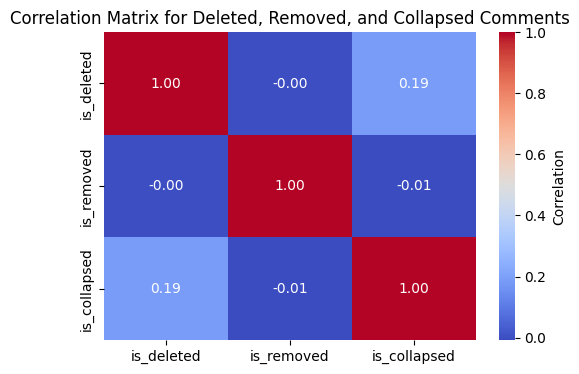

In [97]:
# Calculate Pearson correlation coefficients for binary variables
correlation_matrix = reddit_df[['is_deleted', 'is_removed', 'is_collapsed']].corr()

# Display in heatmap for visualization
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix for Deleted, Removed, and Collapsed Comments")
plt.show()

From above, we can see that the correlation between collapsing comments, deleted comments, and removed comments.
They all have low to no correlation with one another, so each of these will be considered as separate actions.

Therefore, we will be investigating 3 moderation actions: collapsed, deleted, and removed comments -- As they have tangible impact to the comments on Reddit.

### Investigating the Relationships Between the Moderation Actions

#### Analyzing the Proportions of Moderation Actions

We calculate the proportion of each moderation action, so that we can investigate potential patterns.

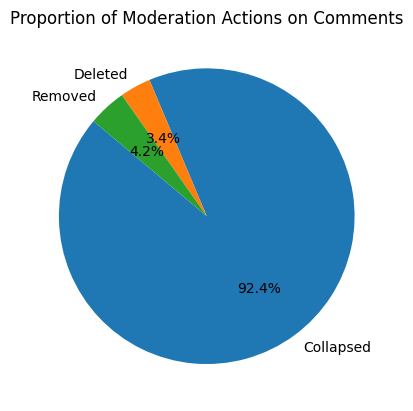

In [98]:
# Count occurrences of each moderation action
collapsed_count = reddit_df['is_collapsed'].sum()
deleted_count = reddit_df['is_deleted'].sum()
removed_count = reddit_df['is_removed'].sum()

# Calculate percentages
collapsed_pct = (collapsed_count / total_rows) * 100
deleted_pct = (deleted_count / total_rows) * 100
removed_pct = (removed_count / total_rows) * 100

# Visualization
labels = ['Collapsed', 'Deleted', 'Removed']
sizes = [collapsed_pct, deleted_pct, removed_pct]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Moderation Actions on Comments')
plt.show()

#### Analysis of Collapsed Comments (with & without Reason Codes)

Since collapsed comments have the highest proportion of 92.4%, it is important to understand them in detail. So we extract and categorize all unique collapsed_reason_code values, grouping by reason type and calculating proportions, and visualize the distribution of reason codes to understand the primary causes of comment collapse more clearly.

In [99]:
# Calculate total number of collapsed comments and display
total_collapsed_comments = reddit_df['is_collapsed'].sum()
print(f"Total number of collapsed comments: {total_collapsed_comments}")

# Split collapsed comments into those with and without a reason code
collapsed_with_reason_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') is not None))]
collapsed_no_reason_df = reddit_df[(reddit_df['is_collapsed']) & (reddit_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') is None))]

# Calculate total number of collapsed comments with reason code
total_collapsed_with_reason = collapsed_with_reason_df.shape[0]
print(f"Total number of collapsed comments with reason code: {total_collapsed_with_reason}")

# Collapsed comments by subreddit, including both with and without reason codes
collapsed_by_subreddit = reddit_df[reddit_df['is_collapsed']].groupby('subreddit_id').size().sort_values(ascending=False)
print("Collapsed Comments by Subreddit (Overall):")
print(collapsed_by_subreddit)

# Count by subreddit for collapsed comments with reason codes
collapsed_with_reason_by_subreddit = collapsed_with_reason_df.groupby('subreddit_id').size().sort_values(ascending=False)
print("Collapsed Comments with Reason Code by Subreddit:")
print(collapsed_with_reason_by_subreddit)

Total number of collapsed comments: 15696
Total number of collapsed comments with reason code: 8804
Collapsed Comments by Subreddit (Overall):
subreddit_id
t5_2qh8c     14567
t5_xnx04      1121
t5_70s6ew        8
dtype: int64
Collapsed Comments with Reason Code by Subreddit:
subreddit_id
t5_2qh8c     7683
t5_xnx04     1113
t5_70s6ew       8
dtype: int64


Collapsed Comments with No Reason Code by Subreddit:
subreddit_id
t5_2qh8c     6884
t5_xnx04        8
t5_70s6ew       0
dtype: int64


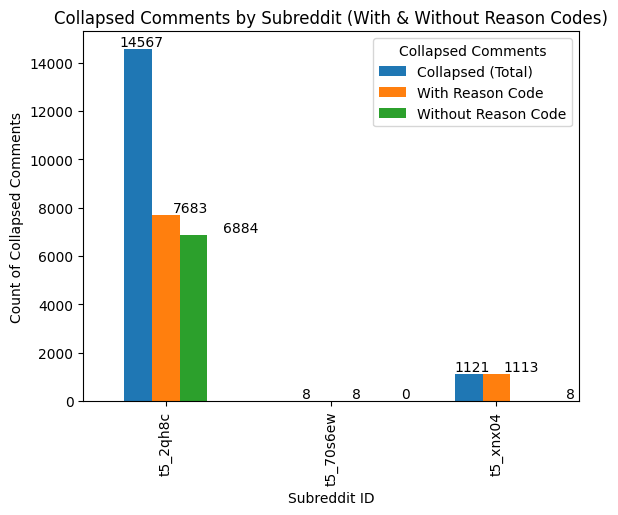

In [100]:
# Count by subreddit for collapsed comments without reason codes
collapsed_no_reason_by_subreddit = collapsed_no_reason_df.groupby('subreddit_id').size().reindex(['t5_2qh8c', 't5_70s6ew', 't5_xnx04'], fill_value=0).sort_values(ascending=False)
print("Collapsed Comments with No Reason Code by Subreddit:")
print(collapsed_no_reason_by_subreddit)

# Subreddit comparison for collapsed comments with and without reason codes
subreddits = ['t5_2qh8c', 't5_70s6ew', 't5_xnx04']
collapsed_counts_subreddit = {
    'Collapsed (Total)': [collapsed_by_subreddit.get(sub, 0) for sub in subreddits],
    'With Reason Code': [collapsed_with_reason_by_subreddit.get(sub, 0) for sub in subreddits],
    'Without Reason Code': [collapsed_no_reason_by_subreddit.get(sub, 0) for sub in subreddits]
}

# Create DataFrame for bar plot
collapsed_counts_df = pd.DataFrame(collapsed_counts_subreddit, index=subreddits)
collapsed_counts_df.plot(kind='bar', title='Collapsed Comments by Subreddit (With & Without Reason Codes)')
plt.xlabel("Subreddit ID")
plt.ylabel("Count of Collapsed Comments")
plt.legend(title='Collapsed Comments')

# Annotate with values for clarity
for i in range(len(collapsed_counts_df.columns)):
    for idx, value in enumerate(collapsed_counts_df.iloc[:, i]):
        plt.text(idx - 0.15 + i * 0.3, value + 0.1, f"{value}", ha='center', va='bottom')

plt.show()

Collapsed Comments with Reason Codes by Subreddit:
moderation    DELETED  LOW_SCORE
subreddit_id                    
t5_2qh8c          576       7107
t5_70s6ew           0          8
t5_xnx04            0       1113


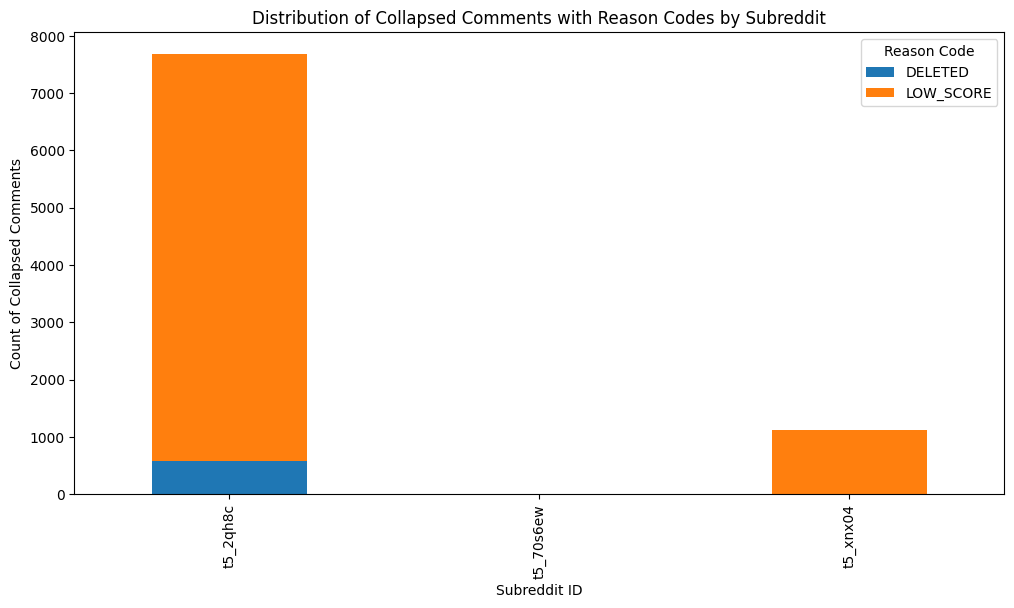

In [101]:
# Subreddit comparison for collapsed comments by reason code
collapsed_with_reason_by_reason_code_subreddit = collapsed_with_reason_df.groupby(['subreddit_id', collapsed_with_reason_df['moderation'].apply(lambda x: x.get('collapsed_reason_code'))]).size().unstack(fill_value=0)

print("Collapsed Comments with Reason Codes by Subreddit:")
print(collapsed_with_reason_by_reason_code_subreddit)

# Visualization of collapsed comments with reason codes by subreddit
collapsed_with_reason_by_reason_code_subreddit.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel("Subreddit ID")
plt.ylabel("Count of Collapsed Comments")
plt.title("Distribution of Collapsed Comments with Reason Codes by Subreddit")
plt.legend(title="Reason Code")
plt.show()

So, it is mostly either low-score comments get collapsed, or some deleted comments are collapsed.

Based on subreddit breakdown, only r/Singapore collapses deleted comments (as well as low score comments). For the other subreddits, they just collapse comments with low score.

Collapsed Comments with No Reason Code by Subreddit:
subreddit_id
t5_2qh8c     6884
t5_xnx04        8
t5_70s6ew       0
dtype: int64


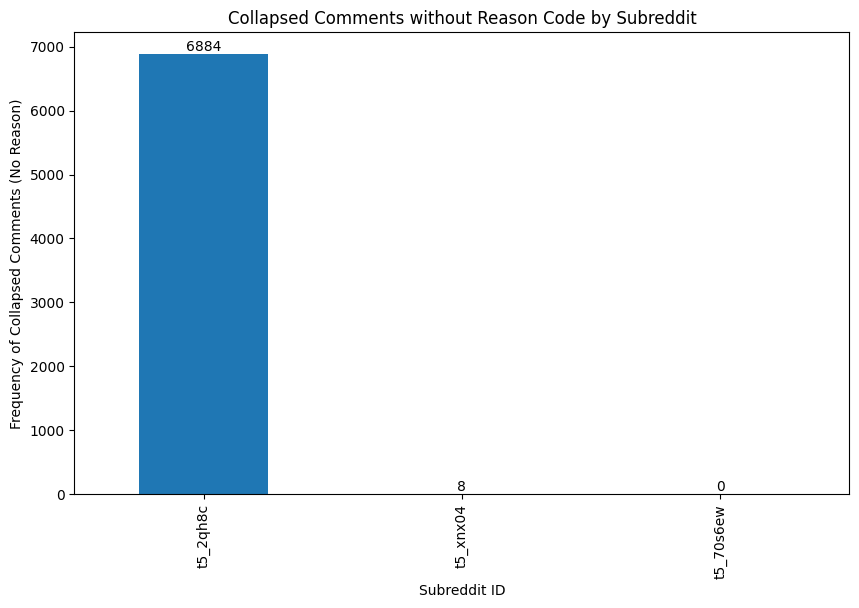

In [102]:
# Count by subreddit for collapsed comments without reason codes
collapsed_no_reason_by_subreddit = collapsed_no_reason_df.groupby('subreddit_id').size().reindex(['t5_2qh8c', 't5_70s6ew', 't5_xnx04'], fill_value=0).sort_values(ascending=False)
print("Collapsed Comments with No Reason Code by Subreddit:")
print(collapsed_no_reason_by_subreddit)

# Display numeric values and visualize for collapsed comments without reason codes by subreddit
plt.figure(figsize=(10, 6))
collapsed_no_reason_bar = collapsed_no_reason_by_subreddit.plot(kind='bar', title='Collapsed Comments without Reason Code by Subreddit')
plt.xlabel("Subreddit ID")
plt.ylabel("Frequency of Collapsed Comments (No Reason)")

# Annotate with values
for idx, value in enumerate(collapsed_no_reason_by_subreddit):
    plt.text(idx, value, f"{value}", ha='center', va='bottom')

plt.show()

We found that a large proportion of collapsed comments (specifically in t5_2qh8c which is r/Singapore) do not have an apparent collapsed_reason_code, which may indicate an automatic or systemic moderation decision. Since they are unjustified, it is important to get to the bottom of them.

/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_20945/2819152897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_no_reason_t5_2qh8c['timestamp'] = pd.to_datetime(collapsed_no_reason_t5_2qh8c['timestamp'], errors='coerce', dayfirst=True)


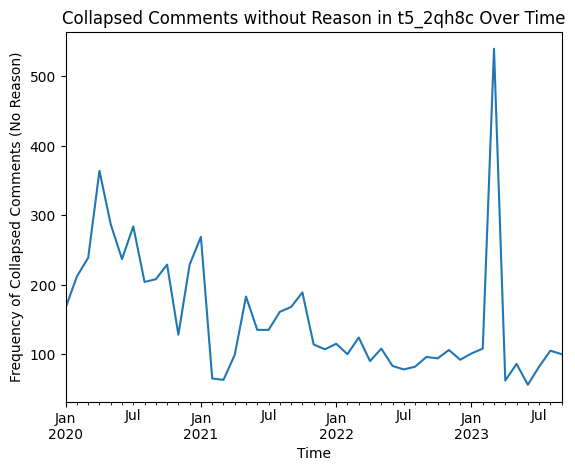

In [103]:
collapsed_no_reason_t5_2qh8c = collapsed_no_reason_df[collapsed_no_reason_df['subreddit_id'] == 't5_2qh8c']

# Ensure 'timestamp' is parsed correctly as datetime and set as index
collapsed_no_reason_t5_2qh8c['timestamp'] = pd.to_datetime(collapsed_no_reason_t5_2qh8c['timestamp'], errors='coerce', dayfirst=True)

# Drop rows with NaT in 'timestamp' and set 'timestamp' as index
collapsed_no_reason_t5_2qh8c = collapsed_no_reason_t5_2qh8c.dropna(subset=['timestamp']).set_index('timestamp')

# Resample and plot
collapsed_no_reason_t5_2qh8c.resample('M').size().plot(title='Collapsed Comments without Reason in t5_2qh8c Over Time')
plt.xlabel("Time")
plt.ylabel("Frequency of Collapsed Comments (No Reason)")
plt.show()

In the latest time period, the collapsed comments without reason in r/Singapore is not too much, so it is a good thing that moderators have justified most of the collapse in comments in the subreddit. But we still want to explore why there are so many unjustified collapses, so we try to see controversiality and other factors.

In [104]:
# Calculate controversiality in collapsed comments without reason
controversial_collapsed_no_reason = collapsed_no_reason_df[collapsed_no_reason_df['is_controversial']]
controversial_count = len(controversial_collapsed_no_reason)
controversial_proportion = (controversial_count / len(collapsed_no_reason_df)) * 100
print(f"Total number of controversial collapsed comments with no reason: {controversial_count}")
print(f"Percentage of controversial comments in collapsed (no reason) comments: {controversial_proportion:.2f}%")

Total number of controversial collapsed comments with no reason: 484
Percentage of controversial comments in collapsed (no reason) comments: 7.02%


Based on the number of comments without reason code, we can tell that t5_2qh8c contains majority of the controversial comments that have been flagged, since the other 2 subreddits barely have unjustified collapsed comments. 

While there is no correlation between collapsed comments and removed comments, since r/Singapore is certainly the most controversial or prevailing in negative comments based on these 14567 out of 15696 collapsed moderations, we will just check for the removed comments to see if there are any other outstanding patterns. 

Total removed comments in t5_2qh8c: 704


/var/folders/yk/rjbvhtb15ts24mbrqtq665zr0000gn/T/ipykernel_20945/6544113.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_comments_t5_2qh8c_df['timestamp'] = pd.to_datetime(removed_comments_t5_2qh8c_df['timestamp'], errors='coerce', dayfirst=True)


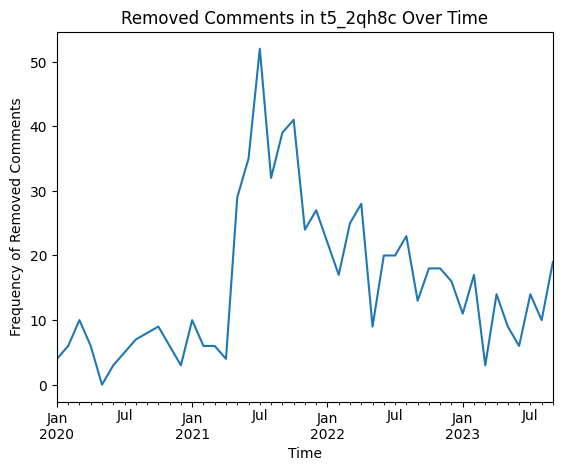

In [105]:
# Calculate removed comments in subreddit t5_2qh8c
removed_comments_t5_2qh8c = reddit_df[(reddit_df['is_removed']) & (reddit_df['subreddit_id'] == 't5_2qh8c')].shape[0]
print(f"Total removed comments in t5_2qh8c: {removed_comments_t5_2qh8c}")

# Filter removed comments in t5_2qh8c
removed_comments_t5_2qh8c_df = reddit_df[(reddit_df['is_removed']) & (reddit_df['subreddit_id'] == 't5_2qh8c')]

# Time-series analysis for removed comments in t5_2qh8c
removed_comments_t5_2qh8c_df['timestamp'] = pd.to_datetime(removed_comments_t5_2qh8c_df['timestamp'], errors='coerce', dayfirst=True)
removed_comments_t5_2qh8c_df = removed_comments_t5_2qh8c_df.dropna(subset=['timestamp'])
removed_comments_t5_2qh8c_df.set_index('timestamp').resample('M').size().plot(title='Removed Comments in t5_2qh8c Over Time')
plt.xlabel("Time")
plt.ylabel("Frequency of Removed Comments")
plt.show()


For some reason, moderators' removed comments have been fluatuating a lot, but at the last time period very little have been removed.

### VISUALISATION 1: MODERATION ACROSS TIME

#### Time-Series Analysis of Moderation Trends

##### Here, we plot moderation trends over time, tracking the proportion of collapsed, deleted, and controversial comments by month. This allows us to identify periods with significant moderation activity, and we investigate further by filtering and inspecting comments from that period.

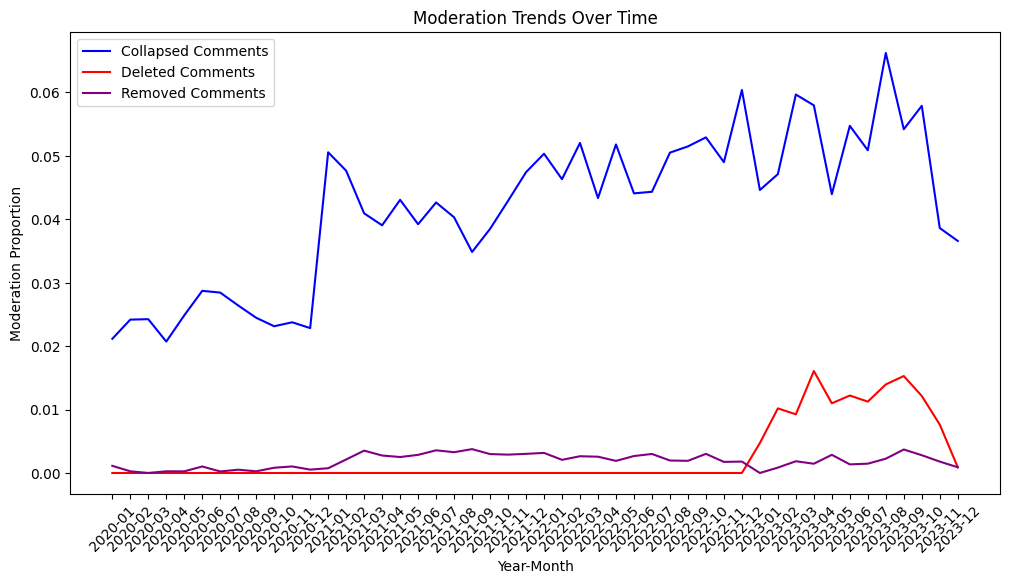

In [106]:
# Convert timestamp to datetime
reddit_df['timestamp'] = pd.to_datetime(reddit_df['timestamp'], errors='coerce')

# Group by year and month to track moderation actions over time
reddit_df['year_month'] = reddit_df['timestamp'].dt.to_period('M')

# Group by year and month for collapsed, deleted, and removed comments
collapsed_trends = reddit_df.groupby(['year_month'])['is_collapsed'].mean()
deleted_trends = reddit_df.groupby(['year_month'])['is_deleted'].mean()
removed_trends = reddit_df.groupby(['year_month'])['is_removed'].mean()

# Plot trends over time
plt.figure(figsize=(12, 6))
plt.plot(collapsed_trends.index.astype(str), collapsed_trends.values, label='Collapsed Comments', color='blue')
plt.plot(deleted_trends.index.astype(str), deleted_trends.values, label='Deleted Comments', color='red')
plt.plot(removed_trends.index.astype(str), removed_trends.values, label='Removed Comments', color='purple')

plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Moderation Proportion')
plt.title('Moderation Trends Over Time')
plt.legend()
plt.show()

We can see that the efforts to collapse comments have started increasing suddenly after Nov 2020, though the trend fluctuates a lot.

For deleted comments, there has not been any action taken at all until Nov 2022, but there has been a sudden strong decrease from Aug 2023 all the way till Dec 2023 and the actions taken for deleted comments are close to 0 again.

For removed comments, they have constantly been fluctuating and there is no significant period of increase or decrease in the moderation action.

### VISUALISATION 2: MODERATION ACROSS SUBREDDITS

#### Moderation by Subreddit

##### We analyze moderation actions across different subreddits using a stacked bar chart. This gives us insight into which subreddits experience more collapses, deletions, or other moderation actions.

Top subreddits by collapsed comments proportion:
              is_collapsed  is_deleted  is_removed
subreddit_id                                      
t5_2qh8c          0.040866    0.001616    0.001975
t5_xnx04          0.031322    0.000000    0.000056
t5_70s6ew         0.001975    0.000000    0.000000


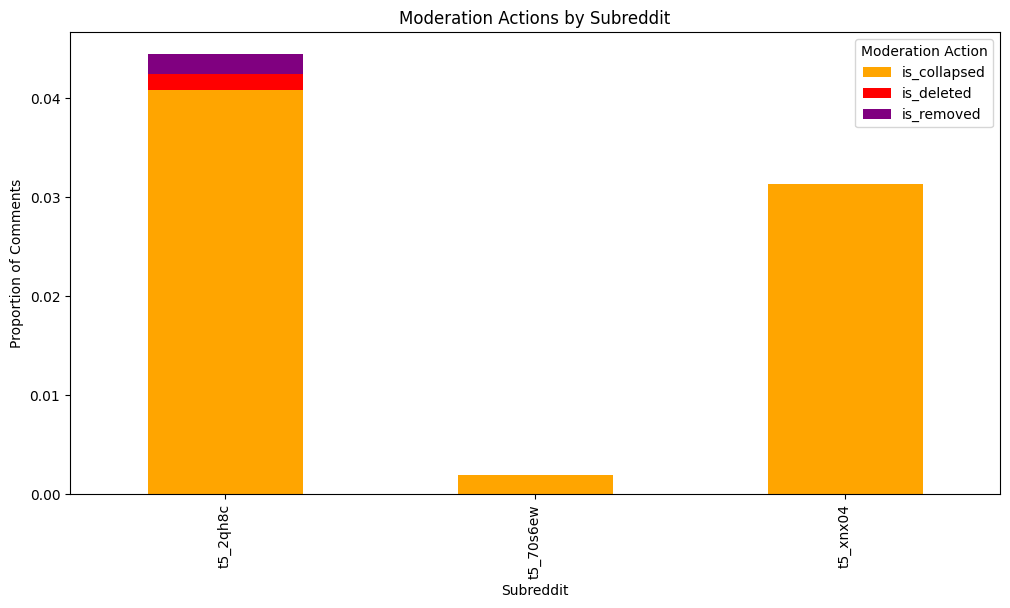

In [107]:
# Proportion of moderation actions by subreddit (collapsed, deleted, removed)
moderation_by_subreddit = reddit_df.groupby('subreddit_id')[['is_collapsed', 'is_deleted', 'is_removed']].mean()

# Sort subreddits by proportion of collapsed comments
collapsed_subreddit_trend = moderation_by_subreddit.sort_values(by='is_collapsed', ascending=False)

# Show top subreddits by collapsed proportion
print("Top subreddits by collapsed comments proportion:")
print(collapsed_subreddit_trend.head())

# Stacked bar chart
ax = moderation_by_subreddit.plot(kind='bar', stacked=True, figsize=(12, 6), color=['orange', 'red', 'purple'])
plt.xlabel('Subreddit')
plt.ylabel('Proportion of Comments')
plt.title('Moderation Actions by Subreddit')
plt.legend(title="Moderation Action")
plt.show()

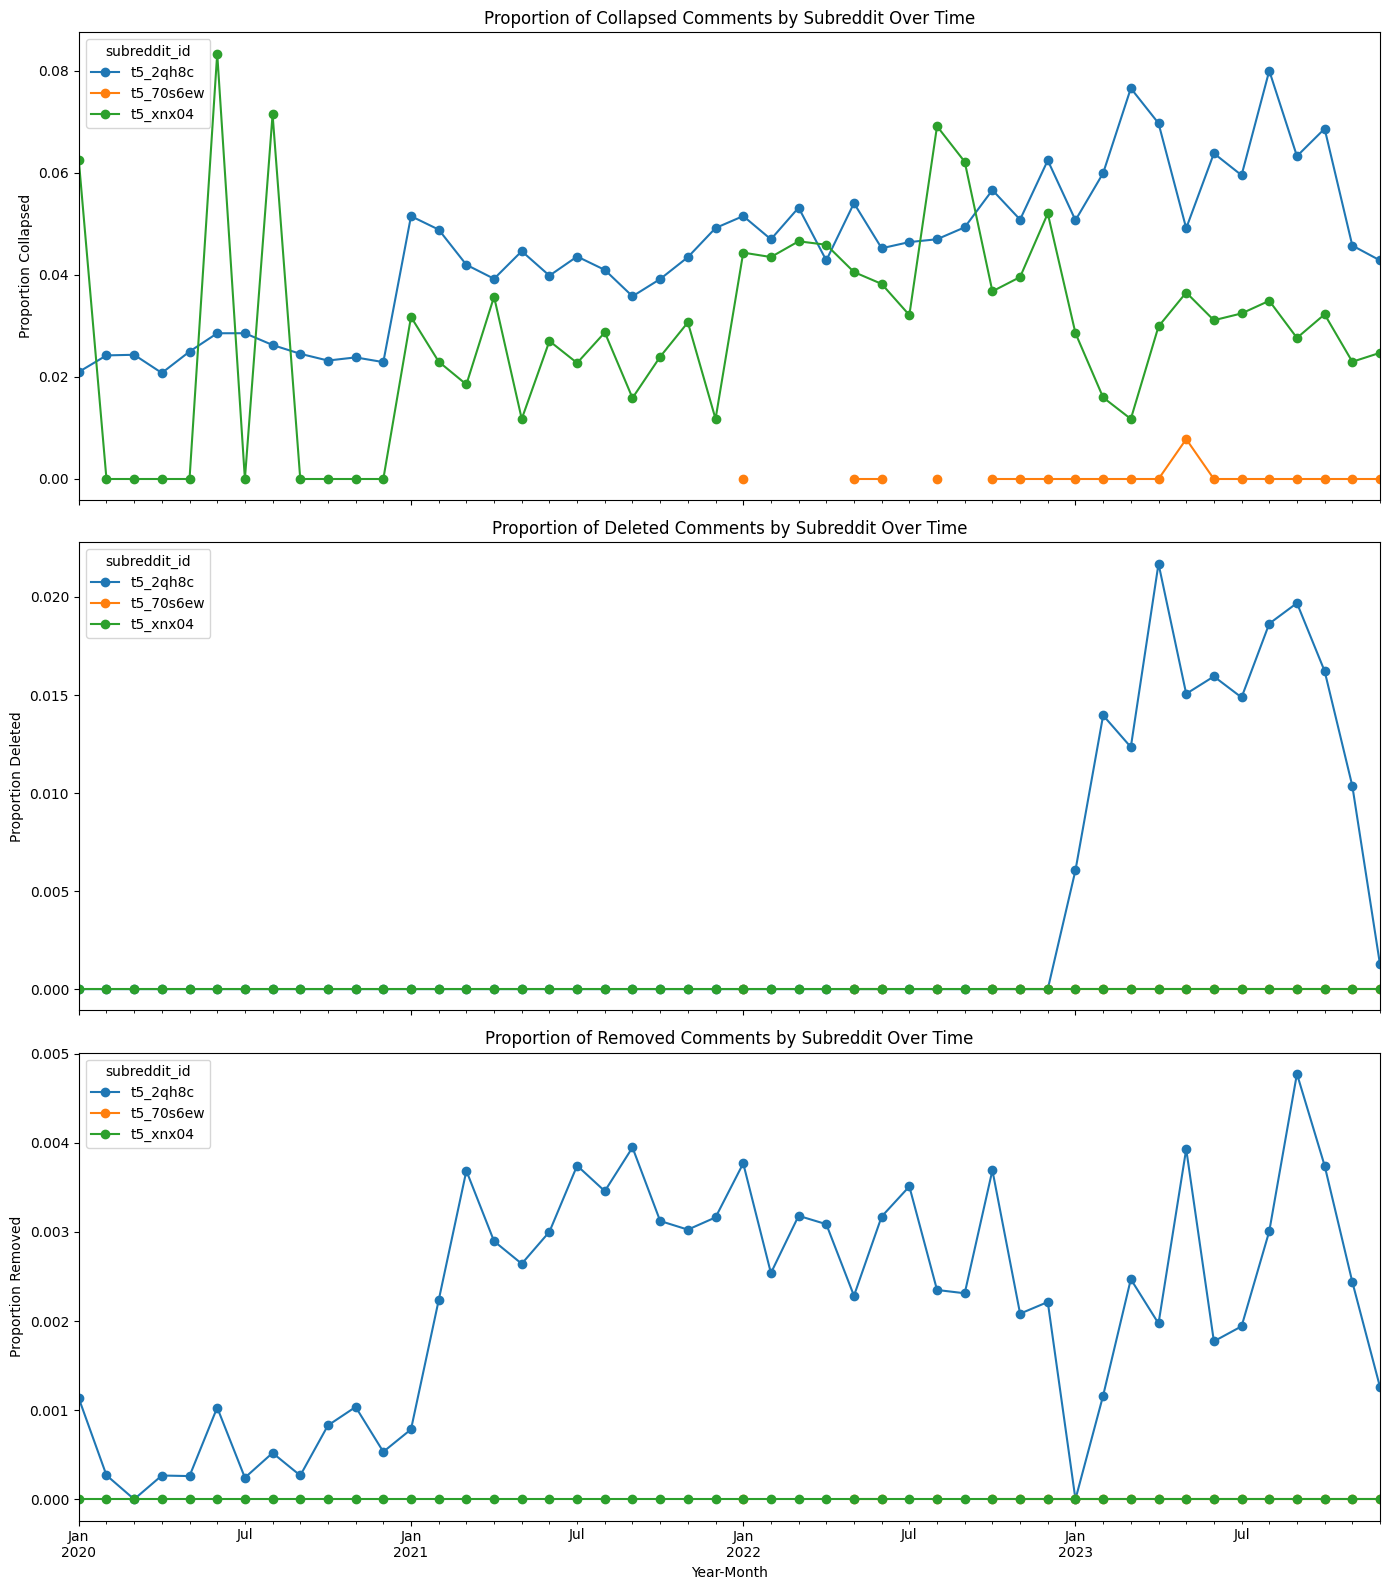

In [108]:
# Ensure 'year_month' is available as a column for time series grouping
reddit_df['year_month'] = reddit_df['timestamp'].dt.to_period('M')

# Calculate proportions of moderation actions by subreddit over time
moderation_trends_by_subreddit = reddit_df.groupby(['subreddit_id', 'year_month'])[['is_collapsed', 'is_deleted', 'is_removed']].mean().unstack(level=0)

# Plot each moderation action separately by subreddit
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# Plot collapsed comments
moderation_trends_by_subreddit['is_collapsed'].plot(ax=axes[0], marker='o')
axes[0].set_title('Proportion of Collapsed Comments by Subreddit Over Time')
axes[0].set_ylabel('Proportion Collapsed')

# Plot deleted comments
moderation_trends_by_subreddit['is_deleted'].plot(ax=axes[1], marker='o')
axes[1].set_title('Proportion of Deleted Comments by Subreddit Over Time')
axes[1].set_ylabel('Proportion Deleted')

# Plot removed comments
moderation_trends_by_subreddit['is_removed'].plot(ax=axes[2], marker='o')
axes[2].set_title('Proportion of Removed Comments by Subreddit Over Time')
axes[2].set_ylabel('Proportion Removed')

# Set x-axis label for the entire figure
plt.xlabel('Year-Month')
plt.tight_layout()
plt.show()

From the charts, only r/Singapore has taken actions to delete and remove comments (in addition to collapsing comments). The other subreddits only have collapsed comments in their efforts to moderate.

We should look at the corresponding toxicity and hatefulness scores across subreddits given these moderation information, since r/Singapore (`t5_2qh8c`) has the most amount of moderation actions taken, followed by r/SingaporeRaw (`t5_xnx04`), and finally r/singaporehappenings (`t5_70s6ew`).